Для первой задачи мы используем данные [Jester Online Joke Recommender System](https://goldberg.berkeley.edu/jester-data/)

**Описание данных**

Файл `train_joke_df.csv` содержит:
- UID - id пользователей
- JID - id шуток, которые 
- Ratin - рейтинг шутки, который проставил пользователь 


Рейтинг имеет значение от -10.00 до 10.00. Могут встречаться значения 99.00, но это обозначает Null (нет рейтинга от пользователя).

Метрика для оценки [RMSE](https://www.codecamp.ru/blog/how-to-interpret-rmse/)

Минимальный RMSE: `4.2238`



In [3]:
%pip install "scikit-surprise==1.1.3"
%pip install "xlrd==2.0.1"

  Using cached scikit-surprise-1.1.3.tar.gz (771 kB)
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp39-cp39-macosx_10_9_x86_64.whl size=1144654 sha256=bed7923fc549f69ca0603e35c871c668c25949f575a1b6cb0dfeebe3b9dcec82
  Stored in directory: /Users/admin/Library/Caches/pip/wheels/c6/3a/46/9b17b3512bdf283c6cb84f59929cdd5199d4e754d596d22784
Successfully built scikit-surprise
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


### Import

In [4]:
import numpy as np
import pandas as pd
from collections import defaultdict
from surprise import Dataset, Reader, KNNWithMeans, accuracy
from surprise.model_selection import GridSearchCV
from surprise.model_selection import train_test_split
from sklearn.model_selection import train_test_split as tts
from surprise.model_selection import KFold

In [37]:
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD as SVD
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import explained_variance_score as evs
from sklearn.metrics import mean_squared_error as mse

In [50]:
from sklearn.metrics import mean_squared_error

In [95]:
from surprise import SVD
from surprise.model_selection import cross_validate
from surprise.model_selection import KFold

### Базовые функции для скоринга и получения рекомендаций

### Загрузка и обработка данных

In [262]:
df = pd.read_csv('train_joke_df.csv')

df.head(5)

,UID,JID,Rating
0,18029,6,-1.26
1,3298,64,-4.17
2,3366,58,0.92
3,12735,92,3.69
4,11365,38,-6.60


In [263]:
# сделаем сортировку и перепишем index
df = df.sort_values(by=['UID', 'JID'])
df = df.reset_index(drop=True)

In [240]:
len(df['JID'].unique())

100

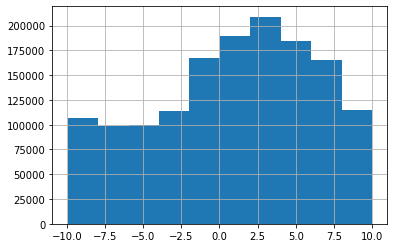

In [179]:
df['Rating'].hist()
plt.show()

In [264]:
# создадим на основе набора данных
# поднабор, который требуется для библиотеки Surprise

# указываем минимальный и максимальный рейтинги
reader = Reader(rating_scale=(-10, 10))

# передаём набор, указывая последовательность колонок: user (raw) ids, item (raw) ids, ratings
# для Surprise - это обязательно
data = Dataset.load_from_df(df[['UID', 'JID', 'Rating']], reader)

In [265]:
trainset_data = data.build_full_trainset()

# сделаем разделение на обучающую и тестовую выборку
trainset, testset = train_test_split(data, test_size=0.2)

## Модель библиотека Surprise SVD

In [259]:
param_grid = {"n_epochs": [15], "lr_all": [0.001, 0.002], "reg_all": [0.05, 0.1,]} #подбор гиперпараметров
gs_d = GridSearchCV(SVD, param_grid, measures=["rmse", "mae"], cv=3)

gs_d.fit(data)


print(gs_d.best_score["rmse"])

# combination of parameters that gave the best RMSE score
print(gs_d.best_params["rmse"])

4.094219708373199
{'n_epochs': 15, 'lr_all': 0.002, 'reg_all': 0.1}


In [266]:
algor_e = SVD(n_epochs = 15, lr_all = 0.002, reg_all = 0.1)
algor_e.fit(trainset)

In [267]:
predictions_e = algor_e.test(testset)

accuracy.rmse(predictions_e)

RMSE: 4.0618


4.061754886949765

In [272]:
trainset_e = algor_e.trainset

predictions_df = pd.DataFrame(predictions_e, columns=['uid', 'iid', 'rui', 'est', 'details'])

predictions_df['№ кол-во пользовательских рейтингов'] = predictions_df.uid.apply(get_num_user_ratings)
predictions_df['№ кол-во рейтингов элементов'] = predictions_df.iid.apply(get_num_item_ratings)
predictions_df['error'] = abs(predictions_df.est - predictions_df.rui)

best_predictions = predictions_df.sort_values(by='error')[:10]
worst_predictions = predictions_df.sort_values(by='error')[-10:]

In [273]:
best_predictions.head(5)

,uid,iid,rui,est,details,№ кол-во пользовательских рейтингов,№ кол-во рейтингов элементов,error
132368,13711,62,-0.19,-0.189971,{'was_impossible': False},47,15899,0.000029
192694,10657,50,3.88,3.879943,{'was_impossible': False},31,15919,0.000057
39597,13133,96,3.40,3.400079,{'was_impossible': False},62,6596,0.000079
288779,15994,70,-6.12,-6.119906,{'was_impossible': False},56,12928,0.000094
84909,4356,29,5.92,5.919893,{'was_impossible': False},46,15871,0.000107


### Для отправки на тестирование

In [276]:
test = pd.read_csv('test_joke_df_nofactrating.csv', index_col=0)
test.head(5)

,UID,JID
InteractionID,,
0,11228,39
1,21724,85
2,16782,56
3,12105,42
4,14427,2


In [277]:
test['Rating'] = test[['UID', 'JID']].apply(lambda x: algor_e.predict(x[0], x[1], verbose=False).est,
                                                      axis = 1)

In [279]:
test['Rating'].to_frame().to_csv('baseline_e.csv')

In [278]:
test['Rating']

InteractionID
0         1.903136
1        -7.512528
2        -0.671561
3         6.958712
4         6.945554
            ...   
362086   -2.518946
362087    2.571102
362088    4.663600
362089   -2.976915
362090   -3.182109
Name: Rating, Length: 362091, dtype: float64